# Obtaining Diagnostic Information from Linking

Beginning with version 0.3, `link_df()` and `link_df_iter()` can include diagnostic data in their output, to give you clues about what the linking algorithm did while linking each particle. This information may help to diagnose errors or bad results from linking, or to verify that the linking algorithm is working properly.

## How to use it

Pass the optional keyword argument `diagnostics=True` to `link_df()` or `link_df_iter()`. The linker will add the "particle" column as usual, along with extra columns whose names begin with "`diag_`". Not all types of diagnostic data may pertain to every particle, so that many entries in these diagnostic columns will have the placeholder value of `NaN` (not a number).

We'll discuss the individual columns and their meanings below, by way of an example: the `bulk_water` movie that was tracked in the walkthrough tutorial.

### Details

1. Diagnostics typically slow down linking by a few percent and consume significant additional memory, so they are turned off by default.
2. If you already ran linking with diagnostics turned on, but no longer want the extra columns cluttering up your results, you can use the `strip_diagnostics()` function to automatically remove all columns whose names start with "`diag_`".
3. The set of diagnostic of columns, and the order in which they appear, is not fixed. Each column is added only if that diagnostic datum was recorded. For example, below we will encounter the `diag_remembered` column that gives information about the `memory` feature. If you did not specify the `memory` option for linking, this column will never be present in your results.
3. For performance reasons, `link_df()` ordinarily does *not* make a copy of its input DataFrame, instead modifying it in-place. For practical reasons, however, with diagnostics enabled `link_df()` must work on a copy. Depending on how it was written, your program may therefore behave differently when diagnostics are turned on! If you suspect a problem, you can instruct `link_df()` to behave more consistently by supplying `copy_features=True`.

## Example

We'll track the `bulk_water` movie much as in the walkthrough, but with `diagnostics=True`. We'll then examine the data we get back. First, we set up our environment:

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

import pims
import trackpy as tp

/Users/dallan/miniconda/envs/trackpy-examples/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


4 frames should be enough for this demonstration.

In [2]:
frames = pims.ImageSequence('../sample_data/bulk_water/*.png', as_grey=True)

f = tp.batch(frames[:4], 11, minmass=66, invert=True, meta=False)

Frame 3: 495 features


We'll link with a larger `search_radius` than in the tutorial, because we want to generate a lot of subnetworks (more on that below).

In [3]:
t = tp.link_df(f, 13, memory=3, diagnostics=True)

Frame 3: 495 trajectories present


/Users/dallan/miniconda/envs/trackpy-examples/lib/python3.4/site-packages/trackpy/linking.py:595: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  features.sort(['particle', t_column], inplace=True)


When we look at the columns in the resulting tracks DataFrame, we see some new names:

In [4]:
list(t.columns)

['x',
 'y',
 'mass',
 'size',
 'ecc',
 'signal',
 'raw_mass',
 'ep',
 'frame',
 'particle',
 'diag_search_range',
 'diag_subnet',
 'diag_subnet_iterations',
 'diag_subnet_size',
 'diag_remembered']

Let's look at the first 5 rows in the results. Because there are so many columns, we'll transpose the data so they fit on the page.

In [5]:
t.head().T

,0,1,2,3,4
x,294.9,295.36,295.97,295.734,310.237
y,5.61132,5.31631,5.62762,5.84352,6.52064
mass,345.95,388.203,373.437,392.386,237.16
size,2.55858,2.52464,2.6303,2.61764,3.18841
ecc,0.186067,0.214783,0.189075,0.187835,0.00687384
signal,17.8819,18.8833,17.4588,18.5116,5.49444
raw_mass,10719,10786,10710,10750,10487
ep,0.089503,0.0784293,0.0887466,0.0807279,0.156558
frame,0,1,2,3,0
particle,0,0,0,0,1


### `diag_search_range`

`trackpy` didn't record every kind of diagnostic data for every feature. We do notice, however, that there is a `diag_search_range` for everything past the first frame. This column is the value of `search_range` that was used to find a particle and link it. Since the particles in the first frame did not need to be found, `diag_search_range` is null there. But for the subsequent frames, it is the same as the `search_range` we told `link_df()` to use, because those particles were successfully linked.

`diag_search_range` would be a nearly pointless column except that it reveals the workings of adaptive search when that feature is turned on. See the tutorial on adaptive search for a more meaningful look at `diag_search_range`.

### `diag_remembered`

When a particle seems to disappear, `memory` allows its "ghost" to stick around for a few more frames in case that particle reappears. In that event, the `diag_remembered` column records the number of frames for which the particle was missing. Let's look in the 4th frame to see whether this actually happened. Again, we show just the first 5 entires and transpose to fit on the page:

In [6]:
remembered_frame3 = t[(t.frame == 3) & (t.diag_remembered > 0)]

print(len(remembered_frame3), 'remembered particles in frame number 3.')
remembered_frame3.head().T

13 remembered particles in frame number 3.


,242,265,310,873,1038
x,339.717,276.435,111.902,284.111,64.1174
y,58.228,64.4811,70.8655,196.545,232.489
mass,330.074,176.822,327.241,186.937,198.975
size,2.83784,3.22542,2.21055,2.6481,3.2842
ecc,0.0604219,0.168835,0.152832,0.089197,0.104093
signal,11.1272,4.55204,18.2082,6.57517,4.24857
raw_mass,10600,10411,10696,10271,10698
ep,0.107869,0.187151,0.0887687,0.410803,0.0884424
frame,3,3,3,3,3
particle,63,70,82,230,272


One of these particles has a `diag_remembered` value of 2, which means that it was present in the first frame, went missing for 2 frames, and then seemingly reappeared in the fourth frame.

If you are not sure whether memory (or a specific value of the `memory` option) is appropriate for your movie, `diag_remembered` shows you which trajectories and frames to spot-check.

### `diag_subnet`

As you may have also learned in other `trackpy` tutorials (including the one devoted to the topic), how easily subnetworks arise, and how they are resolved, can be crucial to the feasibility and correctness of linking. `trackpy` records diagnostic data whenever it encounters a subnetwork. (If there were no subnetworks at all, the columns discussed here will not be present.) As with memory, these data can help you focus on potential trouble spots.

In our example data, we can see what subnetworks were encountered when linking frames 0 and 1:

In [7]:
subnet_particles = t[(t.frame == 1) & ~(t.diag_subnet.isnull())]

print(len(subnet_particles), 'particles involved in subnets between frames 0 and 1.')
subnet_particles.head().T

87 particles involved in subnets between frames 0 and 1.


,35,171,183,217,221
x,552.664,198.428,98.5585,99.9468,328.583
y,11.499,34.7235,40.5719,52.6163,51.6568
mass,322.581,291.7,233.694,172.662,256.228
size,2.30788,2.54431,3.0722,3.41624,3.34206
ecc,0.112383,0.0819793,0.0102799,0.0974881,0.0920241
signal,18.6746,14.0842,6.36398,3.54713,5.11205
raw_mass,10594,10664,10695,10603,10448
ep,0.113443,0.0975633,0.0918683,0.111118,0.171748
frame,1,1,1,1,1
particle,10,44,47,57,58


The subnet columns are as follows:

**`diag_subnet`** sequentially numbers each subnet as it is encountered. This allows you to count subnets, and identify particles that are in the same subnet. Note that the numbering is sequential over the *entire movie*. Therefore, to count the subnets in a particular frame, use

In [8]:
len(subnet_particles.diag_subnet.unique())

45

We can also take this opportunity to show these subnet particles. This would be the starting point for more in-depth spot checks of how subnets were solved.

<IPython.core.display.Javascript object>


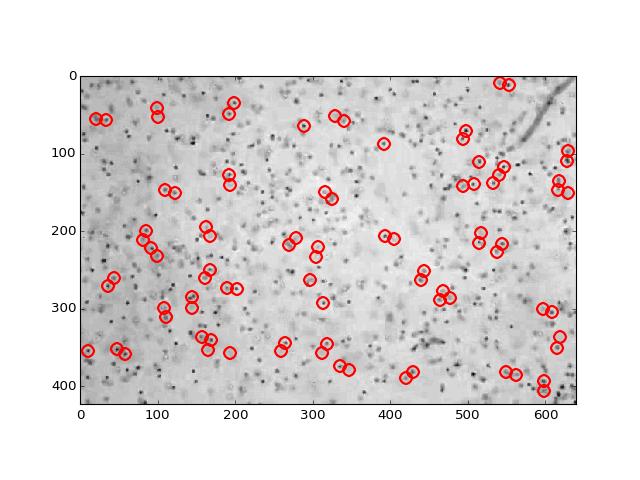

In [9]:
tp.annotate(subnet_particles, frames[1], plot_style={'markersize': 10});

Like `diag_subnet`, the columns `diag_subnet_size` and `diag_subnet_iterations` also pertain to the entire subnet; all members of a subnet have the same values. It would be nice to consolidate these data into a shorter table of the subnets and their properties. To do this, we can use the powerful grouping and aggregation features of Pandas:

In [10]:
subnets = subnet_particles.groupby('diag_subnet')[['diag_subnet_size', 'diag_subnet_iterations']].first()

# Count how many particles in the *present* frame are in each subnet,
# and include it in the results.
subnet_current_sizes = subnet_particles.diag_subnet.value_counts()
subnet_current_sizes.name = 'current_size'
subnets = subnets.join(subnet_current_sizes)

subnets.head()

,diag_subnet_size,diag_subnet_iterations,current_size
diag_subnet,,,
0,3,5,3
1,2,3,2
2,2,3,2
3,1,1,2
4,2,3,2


Each subnet involves a set of trajectories in the past (generally the previous frame), and a set of candidate particles in the present (the frame in which the diagnostic info was recorded). **`diag_subnet_size`** gives the number of particles in the past, and in this example, we computed the `current_size` column to see the number in the present. You can see that some subnets necessitated the ending of a trajectory (e.g. 3 particles to 2), while others  required creation (e.g. 1 to 2).

Finally, the **`diag_subnet_iterations`** column counts the number of possible solutions that were explored by the subnet-solving algorithm before it decided which was best. It is therefore roughly proportional to the time spent solving each subnet. These data are recorded by the numba linker only (`link_strategy='numba'`), which is used by default if `numba` is installed. Almost all of the subnets we're examining are small and were solved quickly:

<IPython.core.display.Javascript object>


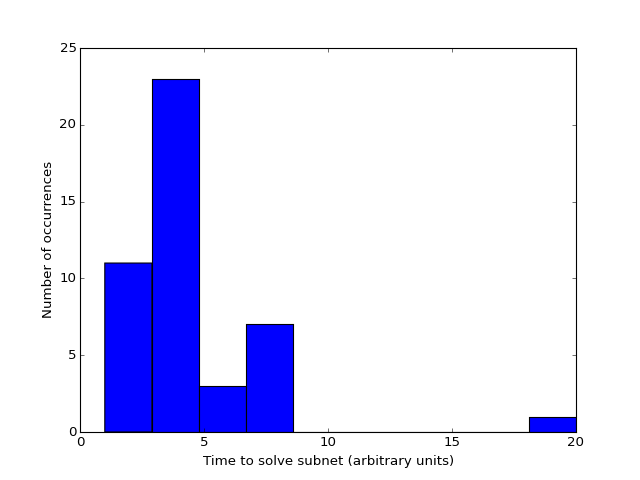

In [11]:
plt.figure()
plt.hist(subnets.diag_subnet_iterations)
plt.xlabel('Time to solve subnet (arbitrary units)')
plt.ylabel('Number of occurrences');

However, a subnet of $\sim$ 25 particles can easily take $10^9$ iterations or more to solve.